# LB Shuffle Augment answer

In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.model_selection import StratifiedKFold
import pickle
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import gc
import seaborn as sns
import lightgbm as lgb
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import itertools
from sklearn.metrics import roc_auc_score
from skopt import gp_minimize
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
TRAIN = 'data/train.csv'
TEST = 'data/test.csv'
SAMPLE = 'data/sample_submission.csv'
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)
gc.enable()

In [53]:
X = train.drop(['ID_code', 'target'], axis=1)
y = train.target
X, Xval, y, yval  = train_test_split(X, y, test_size = 0.05)

In [54]:
def save_model(models, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(models, handle)

In [55]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)
    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [56]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
}

In [57]:
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : 42,
    "verbosity" : 1,
    "seed": 42
}

In [58]:
def lgb_trainer(X, y, params, n_folds):
    skf = StratifiedKFold(n_splits=n_folds)
    models = []
    for train_idx, test_idx in skf.split(X.values, y.values):
            gc.collect()
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_tr, y_tr = augment(X_train.values, y_train.values)
            X_tr = pd.DataFrame(X_tr)
            trn_data = lgb.Dataset(X_tr, label=y_tr)
            test_data = lgb.Dataset(X.values[test_idx], label=y.values[test_idx])
            model_lgb     = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)
            models.append(model_lgb)
            auc = roc_auc_score(y.values[test_idx], model_lgb.predict(X.values[test_idx]))
    return models

In [65]:
def lgb_trainer_no_aug(X, y, params, n_folds):
    skf = StratifiedKFold(n_splits=n_folds)
    models = []
    for train_idx, test_idx in skf.split(X.values, y.values):
            gc.collect()
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_tr, y_tr = X_train.values, y_train.values
            X_tr = pd.DataFrame(X_tr)
            trn_data = lgb.Dataset(X_tr, label=y_tr)
            test_data = lgb.Dataset(X.values[test_idx], label=y.values[test_idx])
            model_lgb     = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)
            models.append(model_lgb)
            auc = roc_auc_score(y.values[test_idx], model_lgb.predict(X.values[test_idx]))
    return models

In [14]:
first_models = lgb_trainer(X, y, lgb_params)

Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.914361	valid_1's auc: 0.898003
[10000]	training's auc: 0.925311	valid_1's auc: 0.900921
Early stopping, best iteration is:
[10949]	training's auc: 0.92701	valid_1's auc: 0.901095
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.913715	valid_1's auc: 0.899052
[10000]	training's auc: 0.924729	valid_1's auc: 0.90176
[15000]	training's auc: 0.933413	valid_1's auc: 0.901897
Early stopping, best iteration is:
[13987]	training's auc: 0.931731	valid_1's auc: 0.90204
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.914625	valid_1's auc: 0.897916
[10000]	training's auc: 0.925372	valid_1's auc: 0.900865
[15000]	training's auc: 0.933833	valid_1's auc: 0.901152
Early stopping, best iteration is:
[13546]	training's auc: 0.931509	valid_1's auc: 0.901205
Training until validation scores don't improve for 4000 rounds.
[5000]	training's 

# Test

In [69]:
def test(X, y, models):
    preds = pd.DataFrame({})
    for i, model in enumerate(models):
        preds[str(i)] = model.predict(X)
        print(f"Fold: {i} \t Score: {roc_auc_score(y, preds[str(i)].values)}")
    averaged_preds = preds.mean(axis=1)
    print(f"Score: {roc_auc_score(y, averaged_preds)}")
    return averaged_preds, preds

In [23]:
q, w = test(Xval, yval, first_models)

Fold: 0 	 Score: 0.897515061872474
Fold: 1 	 Score: 0.8974844339003554
Fold: 2 	 Score: 0.8975224352731692
Fold: 3 	 Score: 0.8983880725147866
Fold: 4 	 Score: 0.8962125789988986
Score: 0.8986053042429611


# Create answer

In [51]:
codes = test.ID_code
df_test = test.drop('ID_code', axis=1)
answer = [model.predict(df_test, num_iteration=model.best_iteration) for model in models]

AttributeError: 'function' object has no attribute 'ID_code'

In [8]:
ans = np.array(answer)
a = np.average(ans, axis=0)

In [9]:
answer_df = pd.DataFrame({
    'ID_code' : codes,
    'target' : a
})
answer_df.to_csv('answer_9_lb_aug.csv', index=False)

In [10]:
save_model(models, 'lb_aug_901_cv10.m')

# Augment #2 (bin-ing)

In [59]:
new_params = {
    'bagging_freq': 5,
    'bagging_fraction': 0.890,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.109,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 41.37,
    'min_sum_hessian_in_leaf': 28.77,
    'num_leaves': 20,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'lambda_l1': 0.486,
     'lambda_l2': 2.6219,
}

In [60]:
def bin_augment(X):
    uniques = X.nunique()    
    bins = {}
    df = X.copy()
    for column in X.columns:
        bin_hash = uniques[column] // 20
        if bin_hash > 100:
            bin_hash = 100
        df[f"bin_{column}"], bins[column] = pd.cut(X[column], bin_hash, labels= [i for i in range(bin_hash)], retbins=True) 
    return to_numeric(df), bins

def to_numeric(df):
    for column in df.columns:
        df[column] = pd.to_numeric(df[column])
    return df     

def test_bin_augment(X, bins):
    uniques = X.nunique()    
    df = X.copy()
    for column in X.columns:
        bin_hash = uniques[column] // 20
        if bin_hash > 100:
            bin_hash = 100
        df[f"bin_{column}"] = pd.cut(X[column], bins=bins[column], labels=False) 
    return to_numeric(df)

In [61]:
X_binned, bins = bin_augment(X)

In [62]:
val_x = test_bin_augment(Xval, bins)

In [63]:
X_binned.shape

(190000, 400)

In [66]:
bin_models = lgb_trainer_no_aug(X_binned, y, new_params, n_folds = 10)

Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.927816	valid_1's auc: 0.894424
[10000]	training's auc: 0.945961	valid_1's auc: 0.896321
Early stopping, best iteration is:
[10839]	training's auc: 0.948538	valid_1's auc: 0.896485
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.927217	valid_1's auc: 0.898672
[10000]	training's auc: 0.945631	valid_1's auc: 0.90149
[15000]	training's auc: 0.959999	valid_1's auc: 0.90147
Early stopping, best iteration is:
[13089]	training's auc: 0.954845	valid_1's auc: 0.901645
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.927853	valid_1's auc: 0.890624
[10000]	training's auc: 0.945999	valid_1's auc: 0.892794
Early stopping, best iteration is:
[9457]	training's auc: 0.944306	valid_1's auc: 0.892945
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.926538	valid_1's auc: 0.905305
[10000]	training's 

In [39]:
# skf = StratifiedKFold(n_splits=10)
# bin_models = []
# for train_idx, test_idx in skf.split(X_binned.values, y.values):
#         X_train, ytrain = X_binned.iloc[train_idx], y.iloc[train_idx]
#         X_tr, y_tr = augment(X_train.values, ytrain.values)
#         X_tr = pd.DataFrame(X_tr)
#         trn_data = lgb.Dataset(X_tr, label=y_tr)
#         test_data = lgb.Dataset(X_binned.values[test_idx], label=y.values[test_idx])
#         model_lgb = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)
#         bin_models.append(model_lgb)
#         auc = roc_auc_score(y.values[test_idx], model_lgb.predict(X_binned.values[test_idx]))

In [67]:
save_model(bin_models, "idk_stupid_bin.m")

In [43]:
q, w = test(val_x, yval, bin_models)

Fold: 0 	 Score: 0.8997628105772392
Fold: 1 	 Score: 0.897699849701752
Fold: 2 	 Score: 0.8984115353905406
Fold: 3 	 Score: 0.898697806584942
Fold: 4 	 Score: 0.8983126673242215
Fold: 5 	 Score: 0.8982486731482787
Fold: 6 	 Score: 0.8988506880841669
Fold: 7 	 Score: 0.8993218965760181
Fold: 8 	 Score: 0.8994424874360056
Fold: 9 	 Score: 0.8990419660889578
Score: 0.8994592785684093


In [70]:
q, w = test(val_x, yval, bin_models)

Fold: 0 	 Score: 0.8988681888032579
Fold: 1 	 Score: 0.8982155849719852
Fold: 2 	 Score: 0.898358649917888
Fold: 3 	 Score: 0.8976797755533203
Fold: 4 	 Score: 0.899158806577835
Fold: 5 	 Score: 0.8984488454155346
Fold: 6 	 Score: 0.8982855302668833
Fold: 7 	 Score: 0.8984893458210313
Fold: 8 	 Score: 0.8986090956686349
Fold: 9 	 Score: 0.8986002293636477
Score: 0.8993433570742332


# Make answer

In [72]:
def make_answer(models, bins):
    answer_qdf = pd.read_csv('data/test.csv')
    test_labels = answer_qdf.ID_code
    answer_qdf = answer_qdf.drop('ID_code', axis=1)
    answer_qdf = test_bin_augment(answer_qdf, bins)
    y_preds = {}
    for i, model in enumerate(models):
            print(f"On fold: {i}")
            y_preds[str(i)] = model.predict(answer_qdf)
    y_preds = pd.DataFrame(y_preds)
    answer_df = pd.DataFrame({
        'ID_code' : test_labels,
        'target' : y_preds.mean(axis = 1),
        })
    return answer_df 

In [73]:
answer_df = make_answer(bin_models, bins)

On fold: 0
On fold: 1
On fold: 2
On fold: 3
On fold: 4
On fold: 5
On fold: 6
On fold: 7
On fold: 8
On fold: 9


In [74]:
answer_df.head()

,ID_code,target
0,test_0,0.110535
1,test_1,0.216304
2,test_2,0.166457
3,test_3,0.189949
4,test_4,0.041769


In [77]:
!ls *csv

answer_10_gpu_lgbm.csv
answer_11_gpu_lgbm_and_pred_best.csv
answer_12_lgbm_bin_trainednotonval.csv
answer_13_lgbm_bin_trainednotonval.csv
answer_1_simple_gbm.csv
answer_2_lgbm_with_CV10.csv
answer_3_lgbm_with_augmented_data_smote_and_shiz.csv
answer_4_lgbm_with_augmented_data_smote_and_shiz_and_super_learner.csv
answer_5_lgbm_with_only_random_augmented_data.csv
answer_6_lgbm_with_best_and_random_averaged.csv
answer_7_lgbm_ORbwRandomAndBest.csv
answer_8_lgbm_AveragedORbwRandomAndBest.csv
answer_9_lb_aug.csv
init3.csv
test_augmented.csv
train_augmented.csv


In [75]:
answer_df.to_csv('answer_13_lgbm_bin_trainednotonval.csv', index = False)

# Blender

In [78]:
s1 = pd.read_csv('answer_13_lgbm_bin_trainednotonval.csv')['target']
s2 = pd.read_csv('answer_11_gpu_lgbm_and_pred_best.csv')['target']
s3 = pd.read_csv('init3.csv')['target']
s4 = pd.read_csv('answer_9_lb_aug.csv')['target']

In [80]:
solutions_set = pd.DataFrame({'s1': s1, 's2': s2, 's3': s3, 's4': s4})

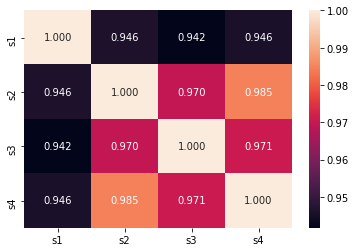

In [81]:
kendall = solutions_set.corr(method = 'kendall')
sns.heatmap(kendall, annot = True, fmt = ".3f")

In [89]:
submission = pd.read_csv('answer_9_lb_aug.csv')
submission.head()

,ID_code,target
0,test_0,0.146873
1,test_1,0.270749
2,test_2,0.239110
3,test_3,0.288975
4,test_4,0.059446


In [90]:
w1 = 0.900
w2 = 0.901
w3 = 0.9011
w4 =  0.9019
submission['target'] =w1*s1 + w2*s2 + w3*s3 + w4*s4 / (w1 + w2 + w3 + w4)

In [91]:
submission.head()

,ID_code,target
0,test_0,0.399770
1,test_1,0.741789
2,test_2,0.643663
3,test_3,0.765199
4,test_4,0.159062


In [84]:
submission.to_csv('answer_14_my_scores_blended.csv', index=False)

# Bayesian optim

In [ ]:
baysian_space  = [
          Integer(5, 20, name='num_leaves'),
          Integer(50, 200, name='min_child_samples'),
          Integer(20, 50,  name='min_data_in_leaf'),
          Integer(1, 10, name='bagging_freq'),
          Real(0.6, 0.9, name='subsample'),
          Real(0.01, 0.2, name='feature_fraction'),
          Real(0.001, 0.01, name='learning_rate'),
          Real(0.1, 0.5, name='bagging_fraction'),
         ]

In [ ]:
def lgb_optim(values):
    params = {'num_leaves': values[0], 
          'min_child_samples': values[1], 
          'min_data_in_leaf': values[2], 
          'bagging_freq': values[3],
            'subsample': values[4],
            'feature_fraction': values[5],
             'learning_rate':values[6],
             'bagging_fraction': values[7],
             'boosting_type': 'gbdt',
             'objective': 'binary',
              'max_depth':-1,
              'metric':'auc',
              'boost_from_average':'false',
               'verbosity': -1,
              'objective': 'binary',
              'tree_learner': 'serial',
               'gpu_platform_id': -1,
             }
    print('\nNext set of params.....',params)
    trn_data = lgb.Dataset(X_binned, label=y)
    val_data = lgb.Dataset(val_x, label=yval)
    model_lgb     = lgb.train(params, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    auc = -roc_auc_score(y_train, model_lgb.predict(X_train))
    return  auc

In [ ]:
res_gp = gp_minimize(lgb_optim, baysian_space, n_calls=20,
                     random_state=0,n_random_starts=10)

# Bayes opt

In [15]:
from bayes_opt import BayesianOptimization

In [16]:
def bayes_parameter_opt_lgbm(X, y, init_round = 15, opt_round = 25, n_folds = 5, random_seed = 6, n_estimators = 10000, 
learning_rate = 0.05, output_process=False, early_stopping_round = 1000, verbose_eval = 2500):
    train_data = lgb.Dataset(data = X, label = y)
    
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, lambda_l1, lambda_l2, min_split_gain, 
    min_child_weight, min_data_in_leaf,min_sum_heassian_in_leaf):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 
        'early_stopping_round': early_stopping_round, 'metric':'auc', 'max_depth':-1}
        params["num_leaves"] = int(round(num_leaves)) #since num_leaves should be a integer so we are converting it to integer
        params['feature_fraction'] = max(min(feature_fraction, 1), 0) # it should be between 0 to 1
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0) # it should be between 0 to 1
        params['lambda_l1'] = max(lambda_l1, 0) # it should be greater than 0
        params['lambda_l2'] = max(lambda_l2, 0) # it should be greater than 0
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_heassian_in_leaf'] = int(round(min_sum_heassian_in_leaf))
        cv_result = lgb.cv(params, train_data, nfold=5, seed=random_seed, stratified=True, verbose_eval = verbose_eval, 
        metrics=['auc'])
        return max(cv_result['auc-mean'])
        
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (2,20),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50),
                                            'min_data_in_leaf':(10,100),
                                            'min_sum_heassian_in_leaf':(1,30)
                                            }, random_state=0)
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    #garbage collect
    gc.collect()
    # return best parameters
    return lgbBO

In [27]:
??bayes_parameter_opt_lgbm

In [17]:
opt_params = bayes_parameter_opt_lgbm(X_binned, y, init_round=10, opt_round=25, n_folds=3, random_seed=5, n_estimators=1000, learning_rate=0.0083, early_stopping_round = 250, verbose_eval = 250)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | min_ch... | min_da... | min_sp... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.804351 + 0.00370799
[500]	cv_agg's auc: 0.835845 + 0.00262113
[750]	cv_agg's auc: 0.851732 + 0.00230812
[1000]	cv_agg's auc: 0.861644 + 0.00229497
|  1        |  0.8616   |  0.9098   |  0.6722   |  3.014    |  1.635    |  24.06    |  68.13    |  0.04432  |  26.86    |  19.35    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.802309 + 0.00390135
[500]	cv_agg's auc: 0.833926 + 0.00277792
[750]	cv_agg's auc: 0.849946 + 0.00241102
[1000]	cv_agg's auc: 0.860061 + 0.00225994
|  2        |  0.8601   |  0.8767   |  0.7334   |  2.644    |  1.704    |  46.65    |  16.39    |  0.009626 |  1.586    |  16.99    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.766063 + 0.00585046
[500]	cv_agg's auc: 0.800439 + 0.00433963
[750]	cv_agg's auc: 0.819662 + 0.00355616
[1000]	cv_agg's auc: 0.832577 + 0.00283608
|  3        |  0.8326   |  0.9556   |  0.796    |  4.893    |  2.397    |  25.77    |  80.25    |  0.01271  |  19.56    |  4.58     |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.797094 + 0.00455423
[500]	cv_agg's auc: 0.828968 + 0.00313063
[750]	cv_agg's auc: 0.845672 + 0.0026062
[1000]	cv_agg's auc: 0.856111 + 0.00244238
|  4        |  0.8561   |  0.9889   |  0.5175   |  2.073    |  0.7937   |  39.84    |  51.05    |  0.05727  |  1.545    |  13.12    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.798052 + 0.00426945
[500]	cv_agg's auc: 0.830055 + 0.00299571
[750]	cv_agg's auc: 0.846575 + 0.0025195
[1000]	cv_agg's auc: 0.856984 + 0.00224543
|  5        |  0.857    |  0.9224   |  0.5935   |  4.719    |  2.045    |  21.18    |  49.33    |  0.07007  |  2.747    |  14.0     |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.755002 + 0.0055986
[500]	cv_agg's auc: 0.791773 + 0.00483885
[750]	cv_agg's auc: 0.810976 + 0.00388619
[1000]	cv_agg's auc: 0.824509 + 0.00314276
|  6        |  0.8245   |  0.9341   |  0.2683   |  0.6446   |  0.9463   |  21.37    |  61.32    |  0.04442  |  29.66    |  3.837    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.800188 + 0.00413054
[500]	cv_agg's auc: 0.83121 + 0.00268552
[750]	cv_agg's auc: 0.847372 + 0.00209429
[1000]	cv_agg's auc: 0.857702 + 0.0020925
|  7        |  0.8577   |  0.8418   |  0.229    |  3.266    |  0.7599   |  25.98    |  32.0     |  0.01674  |  4.201    |  13.81    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.791658 + 0.00427151
[500]	cv_agg's auc: 0.823591 + 0.00282952
[750]	cv_agg's auc: 0.840756 + 0.00229753
[1000]	cv_agg's auc: 0.851729 + 0.00215568
|  8        |  0.8517   |  0.8276   |  0.2573   |  1.844    |  2.463    |  9.37     |  85.42    |  0.01051  |  29.32    |  10.44    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.78391 + 0.00528054
[500]	cv_agg's auc: 0.816973 + 0.00366105
[750]	cv_agg's auc: 0.834893 + 0.00279573
[1000]	cv_agg's auc: 0.846066 + 0.00244424
|  9        |  0.8461   |  0.9954   |  0.5839   |  3.696    |  0.1176   |  17.73    |  20.82    |  0.03032  |  4.443    |  7.724    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.815407 + 0.00274954
[500]	cv_agg's auc: 0.838785 + 0.00263138
[750]	cv_agg's auc: 0.853621 + 0.00235276
[1000]	cv_agg's auc: 0.863233 + 0.00209543
|  10       |  0.8632   |  0.8829   |  0.1513   |  3.462    |  1.7      |  16.94    |  57.09    |  0.0103   |  17.7     |  18.73    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.806743 + 0.0037595
[500]	cv_agg's auc: 0.837599 + 0.0025841
[750]	cv_agg's auc: 0.853165 + 0.00237697
[1000]	cv_agg's auc: 0.86309 + 0.00231516
|  11       |  0.8631   |  0.9702   |  0.3791   |  0.5943   |  0.19     |  6.426    |  94.1     |  0.01418  |  3.348    |  19.72    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.805671 + 0.00349787
[500]	cv_agg's auc: 0.836367 + 0.00230713
[750]	cv_agg's auc: 0.852226 + 0.00203798
[1000]	cv_agg's auc: 0.862193 + 0.0019132
|  12       |  0.8622   |  0.9042   |  0.273    |  0.3292   |  2.964    |  48.55    |  97.79    |  0.0231   |  1.018    |  18.16    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.804307 + 0.00381367
[500]	cv_agg's auc: 0.835769 + 0.0026355
[750]	cv_agg's auc: 0.851736 + 0.00212548
[1000]	cv_agg's auc: 0.861744 + 0.00204332
|  13       |  0.8617   |  0.8746   |  0.8777   |  0.1547   |  1.805    |  5.131    |  20.67    |  0.05136  |  1.56     |  19.25    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.806374 + 0.00382035
[500]	cv_agg's auc: 0.837217 + 0.00255943
[750]	cv_agg's auc: 0.852925 + 0.00211807
[1000]	cv_agg's auc: 0.862855 + 0.00212284
|  14       |  0.8629   |  0.9898   |  0.402    |  4.865    |  0.1005   |  14.81    |  98.98    |  0.06419  |  27.88    |  19.76    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.804423 + 0.00395255
[500]	cv_agg's auc: 0.835863 + 0.00274277
[750]	cv_agg's auc: 0.851784 + 0.00224566
[1000]	cv_agg's auc: 0.861789 + 0.00208021
|  15       |  0.8618   |  0.9637   |  0.6525   |  3.71     |  2.305    |  6.288    |  12.0     |  0.07331  |  28.87    |  19.0     |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.812721 + 0.00319035
[500]	cv_agg's auc: 0.83869 + 0.00239314
[750]	cv_agg's auc: 0.854026 + 0.0021262
[1000]	cv_agg's auc: 0.863701 + 0.00199756
|  16       |  0.8637   |  0.9321   |  0.1751   |  0.7865   |  2.924    |  5.305    |  86.85    |  0.0596   |  27.58    |  19.81    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.808179 + 0.0035373
[500]	cv_agg's auc: 0.838123 + 0.00244136
[750]	cv_agg's auc: 0.853641 + 0.0021361
[1000]	cv_agg's auc: 0.863213 + 0.00212871
|  17       |  0.8632   |  0.8386   |  0.2536   |  4.302    |  0.2947   |  49.48    |  48.02    |  0.05659  |  8.224    |  19.89    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.80845 + 0.00345877
[500]	cv_agg's auc: 0.838479 + 0.00272164
[750]	cv_agg's auc: 0.85389 + 0.00218983
[1000]	cv_agg's auc: 0.863671 + 0.00215962
|  18       |  0.8637   |  0.8182   |  0.2456   |  0.1099   |  0.3057   |  29.63    |  70.49    |  0.04968  |  1.307    |  19.94    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.806871 + 0.00388832
[500]	cv_agg's auc: 0.837599 + 0.00253793
[750]	cv_agg's auc: 0.853234 + 0.0021461
[1000]	cv_agg's auc: 0.863002 + 0.00201172
|  19       |  0.863    |  0.8775   |  0.3161   |  4.853    |  0.6181   |  5.165    |  57.87    |  0.06984  |  27.78    |  19.59    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.806001 + 0.00371627
[500]	cv_agg's auc: 0.837238 + 0.00249507
[750]	cv_agg's auc: 0.85298 + 0.00225235
[1000]	cv_agg's auc: 0.862814 + 0.00213552
|  20       |  0.8628   |  0.9962   |  0.3756   |  4.21     |  2.024    |  17.79    |  11.81    |  0.09233  |  2.54     |  19.92    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.807779 + 0.00326938
[500]	cv_agg's auc: 0.837992 + 0.00251634
[750]	cv_agg's auc: 0.853492 + 0.00225866
[1000]	cv_agg's auc: 0.863099 + 0.00205013
|  21       |  0.8631   |  0.8347   |  0.2738   |  3.305    |  2.67     |  44.39    |  11.46    |  0.09724  |  30.0     |  19.84    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.805582 + 0.00395825
[500]	cv_agg's auc: 0.836917 + 0.00289216
[750]	cv_agg's auc: 0.852611 + 0.00249595
[1000]	cv_agg's auc: 0.862454 + 0.00229751
|  22       |  0.8625   |  0.9658   |  0.7865   |  0.3007   |  2.76     |  33.9     |  32.17    |  0.06086  |  14.33    |  19.59    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.80712 + 0.00390487
[500]	cv_agg's auc: 0.837634 + 0.00232035
[750]	cv_agg's auc: 0.853278 + 0.00210966
[1000]	cv_agg's auc: 0.863139 + 0.00205283
|  23       |  0.8631   |  0.8622   |  0.3053   |  2.944    |  1.23     |  48.99    |  97.56    |  0.0184   |  29.84    |  19.95    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.810304 + 0.00333398
[500]	cv_agg's auc: 0.836466 + 0.00281619
[750]	cv_agg's auc: 0.852027 + 0.00220142
[1000]	cv_agg's auc: 0.8619 + 0.00211268
|  24       |  0.8619   |  0.9691   |  0.1735   |  4.105    |  2.718    |  6.8      |  99.7     |  0.01298  |  2.285    |  17.7     |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.828417 + 0.00189422
[500]	cv_agg's auc: 0.844709 + 0.0019895
[750]	cv_agg's auc: 0.855829 + 0.00183882
[1000]	cv_agg's auc: 0.864445 + 0.00181571
|  25       |  0.8644   |  0.8161   |  0.1031   |  3.883    |  2.914    |  46.09    |  33.05    |  0.05564  |  1.767    |  19.9     |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.805544 + 0.00367551
[500]	cv_agg's auc: 0.837006 + 0.00266248
[750]	cv_agg's auc: 0.852687 + 0.00234935
[1000]	cv_agg's auc: 0.862573 + 0.00218455
|  26       |  0.8626   |  0.9828   |  0.8773   |  0.01618  |  0.7366   |  32.58    |  10.24    |  0.0809   |  29.13    |  19.99    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.816134 + 0.00226489
[500]	cv_agg's auc: 0.839528 + 0.00209233
[750]	cv_agg's auc: 0.854452 + 0.00187567
[1000]	cv_agg's auc: 0.863949 + 0.00185723
|  27       |  0.8639   |  0.9433   |  0.1549   |  4.712    |  2.774    |  5.849    |  62.71    |  0.05162  |  1.54     |  19.81    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.808651 + 0.00365375
[500]	cv_agg's auc: 0.83838 + 0.00230898
[750]	cv_agg's auc: 0.853798 + 0.00198408
[1000]	cv_agg's auc: 0.863542 + 0.00189725
|  28       |  0.8635   |  0.8646   |  0.2243   |  4.214    |  0.1337   |  21.73    |  40.05    |  0.03324  |  1.227    |  19.94    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.807482 + 0.00360647
[500]	cv_agg's auc: 0.837993 + 0.00217417
[750]	cv_agg's auc: 0.853557 + 0.00197621
[1000]	cv_agg's auc: 0.863383 + 0.00195979
|  29       |  0.8634   |  0.9024   |  0.2983   |  1.021    |  2.647    |  49.69    |  10.39    |  0.07949  |  1.485    |  19.63    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.80783 + 0.00324202
[500]	cv_agg's auc: 0.838298 + 0.00197489
[750]	cv_agg's auc: 0.853728 + 0.00182758
[1000]	cv_agg's auc: 0.863411 + 0.00191656
|  30       |  0.8634   |  0.9705   |  0.2642   |  0.2139   |  2.489    |  33.94    |  99.58    |  0.04611  |  23.32    |  19.82    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.806889 + 0.00378718
[500]	cv_agg's auc: 0.837569 + 0.00241956
[750]	cv_agg's auc: 0.853194 + 0.00203479
[1000]	cv_agg's auc: 0.863008 + 0.00203313
|  31       |  0.863    |  0.8575   |  0.3286   |  4.878    |  2.388    |  48.32    |  82.81    |  0.06842  |  1.785    |  19.97    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.80443 + 0.00386644
[500]	cv_agg's auc: 0.835975 + 0.00265254
[750]	cv_agg's auc: 0.851961 + 0.00235368
[1000]	cv_agg's auc: 0.861933 + 0.00226682
|  32       |  0.8619   |  0.8404   |  0.7864   |  1.236    |  2.652    |  5.074    |  99.94    |  0.07407  |  23.11    |  19.04    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.806194 + 0.00368187
[500]	cv_agg's auc: 0.837519 + 0.00257102
[750]	cv_agg's auc: 0.853089 + 0.00222403
[1000]	cv_agg's auc: 0.862944 + 0.00216758
|  33       |  0.8629   |  0.8315   |  0.5383   |  0.1236   |  2.518    |  49.61    |  50.94    |  0.02423  |  2.523    |  19.72    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.805381 + 0.00395244
[500]	cv_agg's auc: 0.836712 + 0.00283943
[750]	cv_agg's auc: 0.852541 + 0.00253153
[1000]	cv_agg's auc: 0.862432 + 0.00237195
|  34       |  0.8624   |  0.9525   |  0.7094   |  4.608    |  0.4596   |  46.82    |  99.75    |  0.07681  |  1.697    |  19.98    |


/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/timetraveller/.local/lib/python3.6/site-packages/lightgbm/engine.py:435: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[250]	cv_agg's auc: 0.825647 + 0.00215332
[500]	cv_agg's auc: 0.843882 + 0.00216609
[750]	cv_agg's auc: 0.855684 + 0.00172614
[1000]	cv_agg's auc: 0.864943 + 0.00192532
|  35       |  0.8649   |  0.89     |  0.1091   |  0.4864   |  2.622    |  5.637    |  41.38    |  0.002726 |  28.77    |  19.86    |


In [41]:
opt_params.res

[{'target': 0.8616438450660884,
  'params': {'bagging_fraction': 0.909762700785465,
   'feature_fraction': 0.6721514930979355,
   'lambda_l1': 3.0138168803582195,
   'lambda_l2': 1.6346495489906907,
   'min_child_weight': 24.064465970250712,
   'min_data_in_leaf': 68.13047017599905,
   'min_split_gain': 0.04432113391500656,
   'min_sum_heassian_in_leaf': 26.861417022680314,
   'num_leaves': 19.345929689018526}},
 {'target': 0.8600606823851157,
  'params': {'bagging_fraction': 0.8766883037651556,
   'feature_fraction': 0.7333800304661316,
   'lambda_l1': 2.644474598764522,
   'lambda_l2': 1.704133683281797,
   'min_child_weight': 46.65184872316975,
   'min_data_in_leaf': 16.393245237809825,
   'min_split_gain': 0.00962580067045253,
   'min_sum_heassian_in_leaf': 1.586333525769446,
   'num_leaves': 16.987157219862883}},
 {'target': 0.8325770259106328,
  'params': {'bagging_fraction': 0.9556313501899701,
   'feature_fraction': 0.7960097185974554,
   'lambda_l1': 4.89309171116382,
   'lamb

In [47]:
mafuckoffx = 0
for i in opt_params.res:
    if i['target'] > mafuckoffx:
        mafuckoffx = i['target']
        good = i

In [50]:
good['params']

{'bagging_fraction': 0.890035505408337,
 'feature_fraction': 0.10908510767153522,
 'lambda_l1': 0.4863959301227627,
 'lambda_l2': 2.6218935751177073,
 'min_child_weight': 5.63721361853795,
 'min_data_in_leaf': 41.37882463633409,
 'min_split_gain': 0.002725991720530222,
 'min_sum_heassian_in_leaf': 28.771612187427262,
 'num_leaves': 19.85619099470854}

In [ ]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.890,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.109,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 41.37,
    'min_sum_hessian_in_leaf': 28.77,
    'num_leaves': 20,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'lambda_l1': 0.486,
     'lambda_l2': 2.6219,
}